#### 编写MLP，要求如下：
1.1	只能使用numpy编写，不能直接使用pytorch中的linear ，sigmoid等函数；

1.2	完成输入层，隐含层和输出层；

1.3	编写损失函数以及激活函数；

1.4	编写训练过程，预测过程；

1.5	回归或分类均可，数据集可自行选择。


In [1]:
import numpy
import matplotlib.pyplot as plt

In [2]:
import numpy as np
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)


def cross_entropy_loss(predictions, labels):
    m = labels.shape[0]
    log_likelihood = -np.log(predictions[range(m), labels])
    loss = np.sum(log_likelihood) / m
    return loss


def derivative_cross_entropy(predictions, labels):
    m = labels.shape[0]
    grad = predictions.copy()
    grad[range(m), labels] -= 1
    grad = grad / m
    return grad


def tanh(x):
    # 手动实现tanh函数
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))


def derivative_tanh(x):
    return 1 - tanh(x) ** 2


# 小批量随机梯度下降的数据打包函数
def batch_generator(X, y, batch_size=32):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, X.shape[0] - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]


# MLP类
class MLP:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.W1 = np.random.randn(input_size, hidden_size1) / np.sqrt(input_size)
        self.b1 = np.zeros(hidden_size1)
        self.W2 = np.random.randn(hidden_size1, hidden_size2) / np.sqrt(hidden_size1)
        self.b2 = np.zeros(hidden_size2)
        self.W3 = np.random.randn(hidden_size2, output_size) / np.sqrt(hidden_size2)
        self.b3 = np.zeros(output_size)

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = tanh(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = tanh(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = softmax(self.z3)
        return self.a3


# 对于MLP，我们需要一个训练函数来执行前向和后向传播
def train(model, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate):
    n_batches = int(np.ceil(X_train.shape[0] / batch_size))
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        for X_batch, y_batch in batch_generator(X_train, y_train, batch_size):
            # 前向传播
            output = model.forward(X_batch)

            # 计算损失
            loss = cross_entropy_loss(output, y_batch)

            # 反向传播
            dZ3 = derivative_cross_entropy(output, y_batch)
            dW3 = np.dot(model.a2.T, dZ3)
            db3 = np.sum(dZ3, axis=0, keepdims=True)

            dA2 = np.dot(dZ3, model.W3.T)
            dZ2 = dA2 * derivative_tanh(model.z2)
            dW2 = np.dot(model.a1.T, dZ2)
            db2 = np.sum(dZ2, axis=0, keepdims=True)

            dA1 = np.dot(dZ2, model.W2.T)
            dZ1 = dA1 * derivative_tanh(model.z1)
            dW1 = np.dot(X_batch.T, dZ1)
            db1 = np.sum(dZ1, axis=0, keepdims=True)

            # 更新权重
            model.W3 -= learning_rate * dW3
            model.b3 -= learning_rate * db3.squeeze()
            model.W2 -= learning_rate * dW2
            model.b2 -= learning_rate * db2.squeeze()
            model.W1 -= learning_rate * dW1
            model.b1 -= learning_rate * db1.squeeze()

        # 这里添加验证逻辑，以监控验证损失和准确性
        val_output = model.forward(X_val)
        val_loss = cross_entropy_loss(val_output, y_val)
        val_predictions = np.argmax(val_output, axis=1)
        val_accuracy = np.mean(val_predictions == y_val)
        if (epoch+1)%10 == 0:
            train_losses.append(loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
        print(
            f'Epoch {epoch + 1}, Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    plt.figure()
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(1,len(val_losses)+1), val_accuracies, label='Validation Accuracy', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [3]:
import numpy as np
from sklearn.datasets import load_iris


def iris_data_load():
    # 加载Iris数据集
    iris = load_iris()
    X, y = iris.data, iris.target

    # 随机打乱数据和标签
    np.random.seed(521)  # 为了可重复性
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # 划分训练集和测试集（例如，80%训练，20%测试）
    test_size_ratio = 0.2
    test_size = int(X.shape[0] * test_size_ratio)
    X_train = X[:-test_size]
    X_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]

    # 手动实现归一化（特征缩放）
    # 计算训练数据的均值和标准差
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    # 对训练数据和测试数据应用归一化
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std

    return np.float32(X_train_scaled), np.float32(X_test_scaled), y_train, y_test

Epoch 1, Loss: 1.4494, Validation Loss: 1.2778, Validation Accuracy: 0.1000
Epoch 2, Loss: 1.3577, Validation Loss: 1.2432, Validation Accuracy: 0.1000
Epoch 3, Loss: 1.2623, Validation Loss: 1.2110, Validation Accuracy: 0.1000
Epoch 4, Loss: 1.1883, Validation Loss: 1.1810, Validation Accuracy: 0.1000
Epoch 5, Loss: 1.1583, Validation Loss: 1.1530, Validation Accuracy: 0.2000
Epoch 6, Loss: 1.2248, Validation Loss: 1.1268, Validation Accuracy: 0.2333
Epoch 7, Loss: 1.1729, Validation Loss: 1.1022, Validation Accuracy: 0.3000
Epoch 8, Loss: 1.1539, Validation Loss: 1.0791, Validation Accuracy: 0.3000
Epoch 9, Loss: 1.0960, Validation Loss: 1.0574, Validation Accuracy: 0.3667
Epoch 10, Loss: 1.0495, Validation Loss: 1.0370, Validation Accuracy: 0.4000
Epoch 11, Loss: 0.8941, Validation Loss: 1.0177, Validation Accuracy: 0.4000
Epoch 12, Loss: 0.8461, Validation Loss: 0.9995, Validation Accuracy: 0.4667
Epoch 13, Loss: 0.9454, Validation Loss: 0.9823, Validation Accuracy: 0.4667
Epoch 14

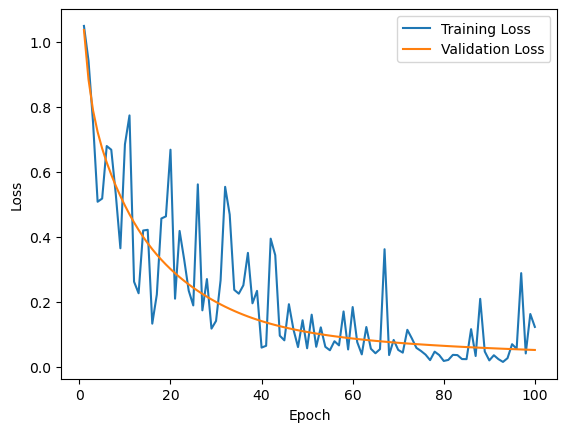

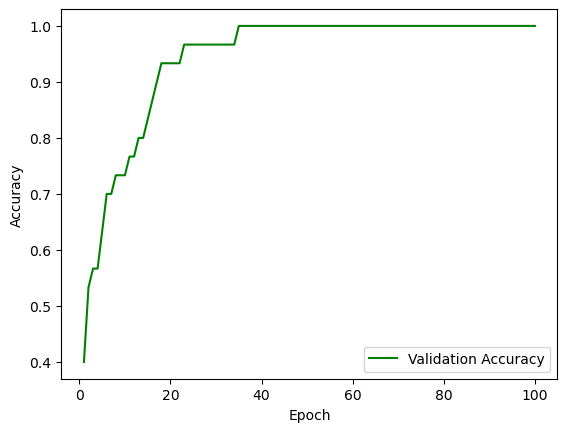

Test Loss: 0.0518, Test Accuracy: 1.0000


In [4]:


# 加载数据
X_train_scaled, X_test_scaled, y_train, y_test = iris_data_load()
# 训练模型
input_size = X_train_scaled.shape[1]
hidden_size1 = 8
hidden_size2 = 16
output_size = len(np.unique(y_train))  # 根据类别数量来设置
model = MLP(input_size, hidden_size1, hidden_size2, output_size)

# 转换标签为one-hot编码
y_train_one_hot = np.eye(output_size)[y_train]
y_test_one_hot = np.eye(output_size)[y_test]

train(model, X_train_scaled, y_train, X_test_scaled, y_test, epochs=1000, batch_size=4, learning_rate=1e-3)

# 最后，使用测试集评估模型性能
test_output = model.forward(X_test_scaled)
test_loss = cross_entropy_loss(test_output, y_test)
test_predictions = np.argmax(test_output, axis=1)
test_accuracy = np.mean(test_predictions == y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')